## Initial set up
### Import packages and take an initial peak of the data before diving into analysis

First, let's import everything we need and define a few functions to clean up our data.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import re
import codecs
import string

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

from functools import reduce

RANDOM_STATE = 777

def neatify_headers(df):
    old_col_headers = list(df)
    new_col_headers = [och.replace(' ', '') for och in old_col_headers]
    rename_headers_map = {och: nch for och, nch in zip(old_col_headers, new_col_headers)}
    return df.rename(columns=rename_headers_map)

def standardize_text(df, text_field):
    df['standarized_annotation'] = df[text_field].str.replace(r"http\S+", "")
    df['standarized_annotation'] = df['standarized_annotation'].str.replace(r"http", "")
    df['standarized_annotation'] = df['standarized_annotation'].str.replace(r"@\S+", "")
    df['standarized_annotation'] = df['standarized_annotation'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df['standarized_annotation'] = df['standarized_annotation'].str.replace(r"@", "at")
    df['standarized_annotation'] = df['standarized_annotation'].str.strip()
    df['standarized_annotation'] = df['standarized_annotation'].str.lower()
    #see documentation here: http://docs.python.org/2/library/string.html
    punct_regex = re.compile('[%s]' % re.escape(string.punctuation))
    df['standarized_annotation'] = df['standarized_annotation'].apply(lambda s: punct_regex.sub(u'', s))
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["standarized_annotation"].apply(tokenizer.tokenize)
    # Make a no stop words list of tokens for plotting.
    # This won't get used for actual vectorizing because I will tell TF-IDF to ignore stop words in standarized_annotation.
    df['no_stop_tokens'] = df['tokens'].apply(lambda tkns: list(filter(lambda tkn: tkn not in stopword_set, tkns)))
    return df

Then import the data and standardize the text!

In [2]:
filenames = ('k_2', '3_5', '6_8', '9_12')
dfs = []
for grade_category, filename in enumerate(filenames):
    df = pd.read_csv("cal_dept_of_edu/{}.csv".format(filename))
    df = neatify_headers(df)
    df['GradeCategory'] = grade_category
    dfs.append(df)

df = reduce(lambda a, b: a.append(b), dfs)
standardize_text(df, "Annotation");

And then we can see how balanced our dataset is among the classes.

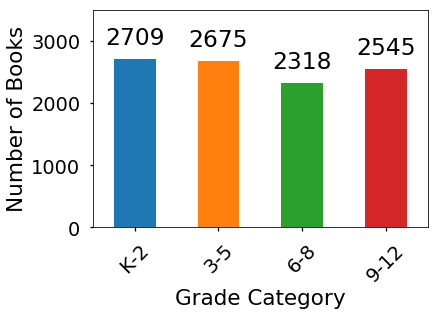

In [3]:
sns.set_context("talk", font_scale=1.5)
ax = df.groupby(['GradeCategory']).count()['TitleID'].plot.bar()
# Consider stratified splitting. Mention alternative of downsampling
# 'Preschool/\nPre-K',
ax.set_xticklabels(['K-2','3-5', '6-8', '9-12'], rotation=45)
ax.set_xlabel('Grade Category')
ax.set_ylabel('Number of Books')
ax.set_ylim([0, 3500])
ys = list(df.groupby(['GradeCategory']).count()['TitleID'])
for x, y in enumerate(ys):
    ax.text(x,y + 350,y,ha='center',va='center')


Since we're going to pass `stop_words='english', analyzer='word'` to the TFIDF vectorizer, a count of the words and histogram of the sentences that excludes stop words is representative of what we will be eventually sending to our trainer

/anaconda3/envs/insight/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


345868 words total, with a vocabulary size of 24177
Max sentence length is 99


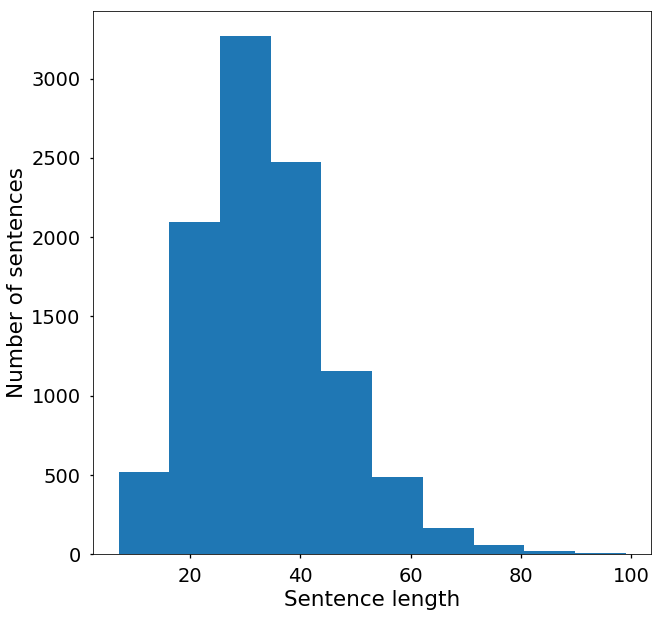

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["no_stop_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["no_stop_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## Now vectorize the standardized book descriptions

In [5]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [6]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['no_stop_tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [9]:
embeddings = get_word2vec_embeddings(word2vec, df)

In [12]:
(len(embeddings), len(embeddings[0]))

(10247, 300)

## And then split the data

First, let's get started with an initial 80/20 training/testing split and then tune the `C` hyperparameter for logistic regression.

In [13]:
list_labels = df["GradeCategory"].tolist()

X_train, X_test, y_train, y_test = train_test_split(embeddings, list_labels, test_size=0.2, random_state=RANDOM_STATE)

In [15]:
(len(X_train), len(X_train[0]))

(8197, 300)

Define the estimator (multinomal logistic regression with balanced class weights)

In [16]:
# Look up newton-cg. Naive bayes
estimator = LogisticRegression(class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=RANDOM_STATE)

Below I've manually tuned `C` using Grid Search, iteratively narrowing the search domain to find when the `best_estimator_.C` converges. (http://scikit-learn.org/stable/modules/grid_search.html)

In [ ]:
grid = {
    'C': np.linspace(1, 2, 4)
}
classifier = GridSearchCV(estimator=estimator, param_grid=grid)
classifier.fit(X_train, y_train)
best_C = classifier.best_estimator_.C
print(best_C, classifier.best_score_)

Define a function for plotting a validation curve to visualize how K fold validation scores look around this optimal point. (http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve)

In [11]:
def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, param_range=np.linspace(.1, 1.0, 5)):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("C (1 / regularization strength)")
    plt.ylabel("Accuracy score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, "C", cv=cv, n_jobs=n_jobs, param_range=param_range, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - (2*train_scores_std),
                 train_scores_mean + (2*train_scores_std), alpha=0.2,
                 color="darkorange")
    plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - (2*test_scores_std),
                 test_scores_mean + (2*test_scores_std), alpha=0.2,
                 color="navy")

    plt.legend(loc="best")
    return plt

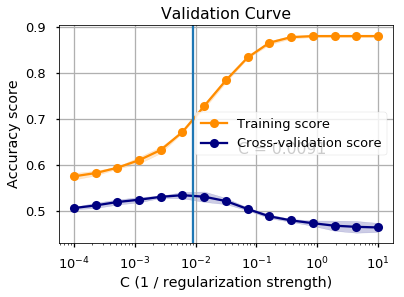

In [12]:
sns.set_context("talk", font_scale=1.0)
title = "Validation Curve"
plot_validation_curve(estimator,
                      title=title,
                      X=X_train,
                      y=y_train,
                      param_range=np.logspace(-4, 1, 15))
plt.axvline(x=best_C)
plt.text(0.05,0.625,"C = {0:.4f}".format(best_C))
plt.show()

Now that we know how strong our regularization needs to be, let's check out the learning curve to ensure that the 80 split for training is sufficiently large to capture variation in the dataset. First, I've defined the function for plotting the learning curve.

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training sample size")
    plt.ylabel("Accuracy score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - (2*train_scores_std),
                     train_scores_mean + (2*train_scores_std), alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - (2*test_scores_std),
                     test_scores_mean + (2*test_scores_std), alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

And in the graph below we can see that we would not benefit from adding more training data

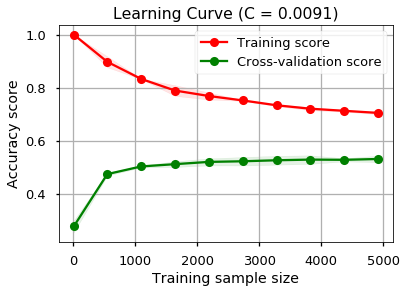

In [22]:
sns.set_context("talk", font_scale=1.0)
train_sizes = np.append([0.001], np.linspace(0.1, 0.9, 9))
title = 'Learning Curve (C = {0:.4f})'.format(best_C)
estimator = LogisticRegression(class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               C=best_C,
                               random_state=RANDOM_STATE)
plot_learning_curve(estimator,
                    title=title,
                    X=X_train,
                    y=y_train,
                    train_sizes=train_sizes)
plt.show()

### Now let's train on the entire training set and make predictions with the testing set

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=best_C,
                         class_weight='balanced',
                         solver='newton-cg', 
                         multi_class='multinomial',
                         n_jobs=-1,
                         random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

Save the trained classifier!

In [17]:
import pickle
with open("clf.pickle","wb") as pickle_output_file:
    pickle.dump(clf, pickle_output_file, pickle.HIGHEST_PROTOCOL)
pickle_output_file.closed

with open("clf.pickle", "rb") as clf_file:
    clf_data = clf_file.read()
    clf = pickle.loads(clf_data)
clf_file.closed

True

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.527, precision = 0.509, recall = 0.527, f1 = 0.512


And plot the confusion matrix

[[0.72568093 0.19649805 0.03307393 0.04474708]
 [0.3588785  0.27663551 0.24672897 0.11775701]
 [0.07249467 0.19402985 0.38379531 0.34968017]
 [0.02631579 0.03759398 0.22180451 0.71428571]]
Normalized confusion matrix


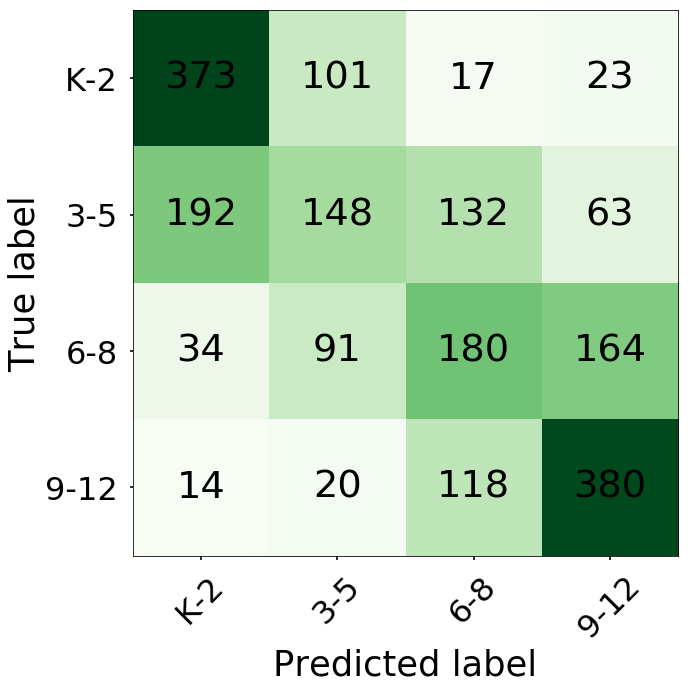

In [15]:
def plot_confusion_matrix_with_labels(cm, classes,
                                      normalize=False,
                                      title='Confusion matrix',
                                      cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt


from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_predicted)
grade_categories = ('K-2','3-5', '6-8', '9-12')
sns.set_context("poster", font_scale=2.0)


fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for (j,i),label in np.ndenumerate(cm):
    ax.text(i,j,label,ha='center',va='center')
plot = plot_confusion_matrix_with_labels(cm, classes=grade_categories, normalize=True, cmap=plt.cm.Greens)
plot.show()

In [18]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottoms':bottom
        }
    return classes

importance = get_most_important_features(bow_counts_vectorizer, clf, 10)

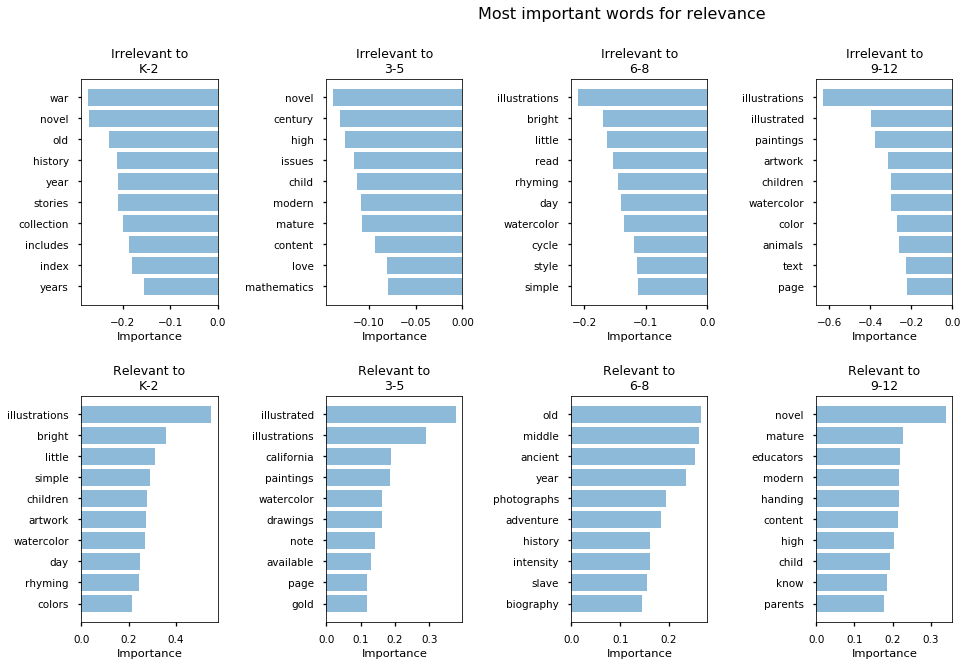

In [19]:
def plot_important_words(importance, name, keys=('bottoms', 'tops',)):
    fig = plt.figure(figsize=(20, 10))
    grade_categories = ('K-2','3-5', '6-8', '9-12')
    for idx, grade_category in enumerate(grade_categories):
        
        top_scores = [a[0] for a in importance[idx][keys[1]]]
        top_words = [a[1] for a in importance[idx][keys[1]]]
        bottom_scores = [a[0] for a in importance[idx][keys[0]]]
        bottom_words = [a[1] for a in importance[idx][keys[0]]]
        
        y_pos = np.arange(len(top_words))
        
        plt.subplot(2, 5, 1 + idx)
        plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
        plt.title('Irrelevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, bottom_words)
        plt.suptitle('Key words', fontsize=16)
        plt.xlabel('Importance')

        plt.subplot(2, 5, 6 + idx)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title('Relevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, top_words)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8, hspace=0.4)
    plt.show()
    
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

## Use Lime to analyze feature importance

In [21]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
c = make_pipeline(bow_counts_vectorizer, clf)
grade_categories = ('K-2','3-5', '6-8', '9-12')
explainer = LimeTextExplainer(class_names=grade_categories)
exp = explainer.explain_instance(list_corpus[2], c.predict_proba, num_features=6, labels=[0, 1, 2, 3])
exp.show_in_notebook(text=True)

/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
